# Комп'ютерний Практикум 2 з Криптоаналізу.

**Тема:** Статистичнi критерiї на вiдкритий текст

**Виконали:** Бондар Петро, Кістаєв Матвій.

**Варіант:** 4


Задача полягала в побудові статистичних критеріїв для розрізнення гіпотез:

$H_0$: $~~$  $X = x_1 x_2 x_3 ... x_n$ – текст української мови

$H_1$: $~~$  $X$ – випадковий текст

Згідно з варіантом, було побудовано декілька критеріїв, емпірично підібрані критичні значення, а також виконано порівняння точності критеріїв для текстів різних довжин та різних способів утворення "випадкової" послідовності


In [1]:
from pypdf import PdfReader
import itertools
import numpy as np
import random
import lzma
import deflate
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

## Завантаження текстів

Як джерело змістовних повідомлень було обрано тексти Конституції України, "Енеїди" Котляревського, "Хто ти?" Артема Чеха та бакалаврські роботи авторів цієї лабораторної роботи (видатних вчених, науковців, дослідників, кандидатів, членів, кореспондентів, академіків).

In [2]:
folder = "documents"
ukr_texts = ["Конституція.pdf", "Енеїда.pdf", "Кучма.pdf", "Хто.pdf", "Bondar_bakalavr.pdf", "Kistaiev_bakalavr.pdf"]

large_text = ""

for text in ukr_texts:
    reader = PdfReader(f"{folder}/{text}")
    for page in reader.pages:
        large_text += page.extract_text() + "\n"


## Обробка текстів та створення змінних для перетворення текстових даних у числові
Очистка тексту та певні допоміжні структури

In [3]:
alph_full = list('АаБбВвГгҐґДдЕеЄєЖжЗзИиІіЇїЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЬьЮюЯя')
alph_1 = list(' абвгґдеєжзиіїйклмнопрстуфхцчшщьюя')
alph_2 = [f'{c1}{c2}' for c1, c2 in itertools.product(alph_1, alph_1)]
lang = []

for c in large_text:
    if c in alph_full:
        lang.append(str.lower(c))
    elif lang[-1] != ' ':
        lang.append(' ')

alph = [' '] + alph_full
lang = "".join(lang)

ARING1 = dict(zip(list(alph_1), range(len(alph_1))))
ARING2 = dict(zip(list(alph_2), range(len(alph_2))))

## Підрахунок частот символів та біграм в текстах українською мовою


In [ ]:
n = len(lang)

lang_1_shreq = dict(zip(alph_1, [0]*len(alph_1)))
for c in lang:
    lang_1_shreq[c] += 1

lang_1_shreq = {key: val / (n - 1) for key, val in lang_1_shreq.items()}


lang_2_shreq = dict(zip(alph_2, [0]*len(alph_2)))
for c1, c2 in zip(lang[:-1], lang[1:]):
    lang_2_shreq[f'{c1}{c2}'] += 1

lang_2_shreq = {key: val / (n - 1) for key, val in lang_2_shreq.items()}

print(n)
print(lang_1_shreq)
print(lang_2_shreq)

## Шифрування, використовувані для спотворення тексту

Для утворення беззмістовних текстів з природніх ми використовуватимо шифр Віженера, а також афінну та біграмну афінну підстановки.

In [5]:
def vigenere_encrypt(ptext: str, key: str):
    r = int(np.ceil(len(ptext) / len(key)))

    ntxt = np.array([ARING1[c] for c in ptext])
    nkey = np.array([ARING1[c] for c in key] * r)

    return "".join([alph_1[c] for c in (ntxt + nkey) % len(alph_1)])


def vigenere_decrypt(ctext: str, key: str):
    r = int(np.ceil(len(ctext) / len(key)))

    ntxt = np.array([ARING1[c] for c in ctext])
    nkey = np.array([ARING1[c] for c in key] * r)

    return "".join([alph_1[c] for c in (ntxt - nkey) % len(alph_1)])


def affine_ecrypt(text: str, a: int, b: int):
    if np.gcd(a, len(alph_1)) != 1:
        raise RuntimeError("Incorrect key, gcd(a, n) != 1")
    
    res = ""
    for i in range(0, len(text)):
        id = (a * ARING1[text[i]] + b) % len(alph_1)
        res += alph_1[id]

    return res


def affine_bigram_ecrypt(text: str, a: int, b: int):
    if np.gcd(a, len(alph_2)) != 1:
        raise RuntimeError("Incorrect key, gcd(a, n) != 1")
    
    res = ""

    for c1, c2 in zip(text[:-1], text[1:]):
        id = (a * ARING2[f'{c1}{c2}'] + b) % len(alph_2)
        res += alph_2[id]

    return res

## Генерація випадкових текстів

Беззмістовні тексти ми генеруватимемо наступними методами:
- Чисто випадковий текст, де кожен символ матиме однакову ймовірність появи на кожній позиції;
- Рекурсивна випадкова послідовність, в якій перші два символи обираються випадково, а кожен наступний є комбінацією двох попередніх за модулем;
- Зашифрований за допомогою шифру Віженера відкритий текст (ключ генерується випадково);
- Зашифрований за допомогою афінного шифру відкритий текст (ключ генерується випадково);
- Зашифрований за допомогою біграмного афінного шифру відкритий текст (ключ генерується випадково).

Змістовні тексти ми отримуватимемо шляхом "вирізання" випадкового підтексту з усього корпусу.

In [6]:
def generate_random_text(length):
    return ''.join(random.SystemRandom().choice(alph_1) for _ in range(length))


def generate_recur(length):
    res = ''
    res += random.SystemRandom().choice(alph_1)
    res += random.SystemRandom().choice(alph_1)
    for _ in range(0, length - 1):
        res += alph_1[(ARING1[res[-1]] + ARING1[res[-2]]) % len(alph_1)]
    return res


def generate_rand_lang_text(length):
    i = random.randrange(0, len(lang) - length)

    return "".join(lang[i:i+length])


def generate_enc_vigenere(length, key_len):
    text = generate_rand_lang_text(length)
    key = generate_random_text(key_len)

    return vigenere_encrypt(text, key)


alph_1_divs = np.array([2, 17, 34])
possible_a_1 = [i for i in range(1, len(alph_1)) if all((i % alph_1_divs) != 0)]

def generate_enc_affine1(length):
    text = generate_rand_lang_text(length)
    key_a = random.SystemRandom().choice(possible_a_1)
    key_b = random.SystemRandom().choice(range(len(alph_1)))

    return affine_ecrypt(text, key_a, key_b)
    

alph_2_divs = np.array([2, 17, 34])
possible_a_2 = [i for i in range(1, len(alph_2)) if all((i % alph_2_divs) != 0)]

def generate_enc_affine2(length):
    text = generate_rand_lang_text(length)
    key_a = random.SystemRandom().choice(possible_a_2)
    key_b = random.SystemRandom().choice(range(len(alph_2)))

    return affine_ecrypt(text, key_a, key_b)


## Функції для обчислення потрібних характеристик для тексту

- Функції для підрахунку частот символів та біграм в обраному тексті.
- Функції для обчислення індексу відповідності (аби було) та усередненої ентропії в обраному тексті.
- Функції для обчислення кількості "порожніх якщиків".
- Функція для обчислення коефіцієнтів стиснення за допомогою lzma та deflate.

In [7]:
def gram_1_shreqs(A, text):
    text_1_shreqs = dict(zip(A, [0]*len(A)))

    for c in text:
        if c in A:
            text_1_shreqs[c] += 1 
    
    return {key: val / (len(text) - 1) for key, val in text_1_shreqs.items()}

def gram_2_shreqs(A, text):
    text_2_shreqs = dict(zip(A, [0]*len(A)))

    for c1, c2 in zip(text[:-1], text[1:]):
        if f'{c1}{c2}' in A:
            text_2_shreqs[f'{c1}{c2}'] += 1 

    return {key: val / (len(text) - 1) for key, val in text_2_shreqs.items()}

def index_of_coincidence(l_gram_counts):
    counts = np.array(list(l_gram_counts.values()))
    N = counts.sum()
    I = sum(count * (count - 1) for count in counts) / (N * (N - 1))

    return I

def avg_entropy(text, l):
    l_gram_shreqs = defaultdict(lambda: 0)

    for i in range(len(text) - l):
        l_gram_shreqs[text[i:i+l]] += 1

    probs = np.array(list(l_gram_shreqs.values())) / (len(text) - l + 1)
    H = -probs.dot(np.log2(probs)) / l

    return H


def n_empty_1_boxes(B_freq, text):
    return sum(np.array(list(gram_1_shreqs(B_freq, text).values())) == 0)

def n_empty_2_boxes(B_freq, text):
    return sum(np.array(list(gram_2_shreqs(B_freq, text).values())) == 0)


def lzma_compression_ratio(text):
    txt = text.encode()
    original_len = len(txt)

    ctxt = lzma.compress(txt)
    compressed_len = len(ctxt)

    return compressed_len / original_len


def deflate_compression_ratio(text):
    txt = text.encode()
    original_len = len(txt)

    ctxt = deflate.gzip_compress(txt, 12)
    compressed_len = len(ctxt)

    return compressed_len / original_len

## Визначення частих та заборонених $l$-грам 

Заборонені символи – найменш часті символи, сумарна ймовірність яких складає $\leq 5\%$.

Заборонені біграми – найменш часті біграми, сумарна ймовірність яких складає $\leq 0.25\%$.

$~$

Популярні символи – найбільщ часті символи, сумарна ймовірність яких складає $\geq 80\%$.

Популярні біграми – найменш часті біграми, сумарна ймовірність яких складає $\geq 80\%$.

$~$

Це визначалось "на око" за допомогою графіків, побудованих нижче.

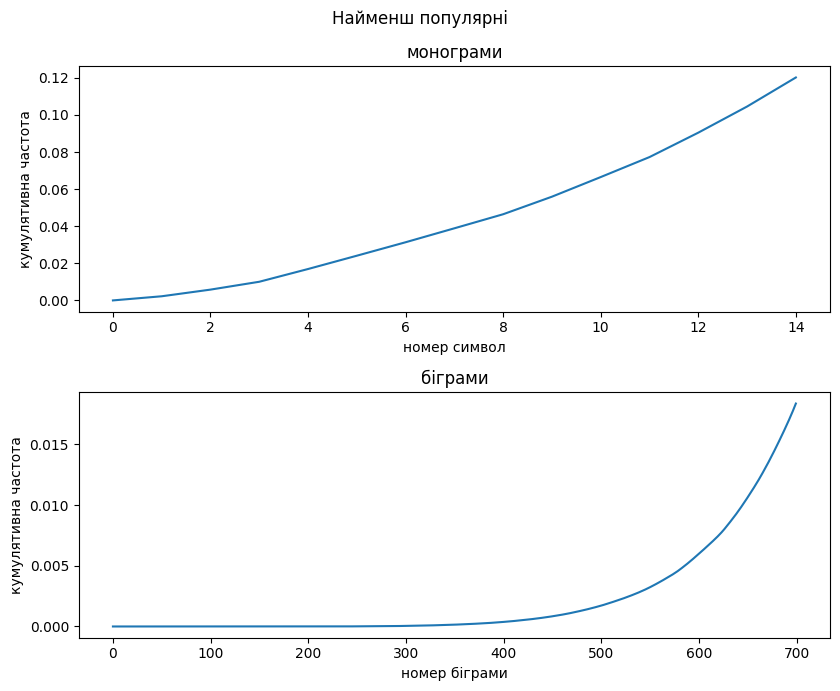

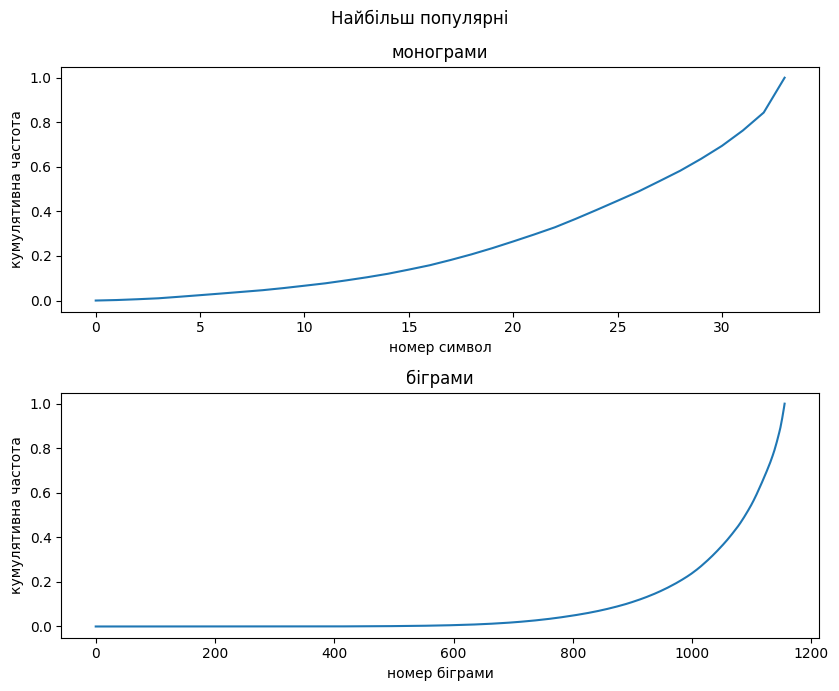

In [17]:
A1_prh = {k: v for k, v in sorted(lang_1_shreq.items(), key=lambda item: item[1])[0:15]}
# print(A1_prh)
A2_prh = {k: v for k, v in sorted(lang_2_shreq.items(), key=lambda item: item[1])[0:700]}
# print(A2_prh)

fig, axs1 = plt.subplots(2, 1)
fig.set_size_inches(8.5, 7)
axs1[0].plot(range(len(A1_prh.keys())), np.cumsum(list(A1_prh.values())))
axs1[0].set_title("монограми")
axs1[0].set_xlabel("номер символ")
axs1[0].set_ylabel("кумулятивна частота")
axs1[1].plot(range(len(A2_prh.keys())), np.cumsum(list(A2_prh.values())))
axs1[1].set_title("біграми")
axs1[1].set_xlabel("номер біграми")
axs1[1].set_ylabel("кумулятивна частота")
fig.suptitle("Найменш популярні")
plt.tight_layout()
A1_prh = list(A1_prh.keys())[0:9]
A2_prh = list(A2_prh.keys())[0:450]


B1_freq = {k: v for k, v in sorted(lang_1_shreq.items(), key=lambda item: item[1])[:]}
# print(B1_freq)
B2_freq = {k: v for k, v in sorted(lang_2_shreq.items(), key=lambda item: item[1])[:]}
# print(B2_freq)

fig, axs2 = plt.subplots(2, 1)
fig.set_size_inches(8.5, 7)
axs2[0].plot(range(len(B1_freq.keys())), np.cumsum(list(B1_freq.values())))
axs2[0].set_title("монограми")
axs2[0].set_xlabel("номер символ")
axs2[0].set_ylabel("кумулятивна частота")
axs2[1].plot(range(len(B2_freq.keys())), np.cumsum(list(B2_freq.values())))
axs2[1].set_title("біграми")
axs2[1].set_xlabel("номер біграми")
axs2[1].set_ylabel("кумулятивна частота")
fig.suptitle("Найбільш популярні")
plt.tight_layout()


B1_freq = list(B1_freq.keys())[14:]
B2_freq = list(B2_freq.keys())[850:]


lang_1_entropy = avg_entropy("".join(lang), 1)
lang_2_entropy = avg_entropy("".join(lang), 2)


## Визначення функцій, що обчислюють статистики критеріїв

Критерії обрані згідно відповідно варіанту 4:

- Критерії 1.0-1.3: Критерії, що ґрунтуються на підрахунку заборонених символів/біграм.
- Критерій 3.0: Критерій, що ґрунтується на обчисленні відхилення усередненої ентропії від теоретичного значення.
- Критерій 5.1: Критерій порожніх ящиків на основі частих символів/біграм.
- Критерій (структурний): Ґрунтується на коефіцієнті стиснення текстів за допомогою алгоритму DEFLATE 

In [18]:
def crit_10_stat(text, l):
    if l == 1:
        return max(np.array(list(gram_1_shreqs(A1_prh, text).values())))
    elif l == 2:
        return max(np.array(list(gram_2_shreqs(A2_prh, text).values())))

def crit_11_stat(text, l):
    if l == 1:
        return sum(np.array(list(gram_1_shreqs(A1_prh, text).values())) > 0)
    elif l == 2:
        return sum(np.array(list(gram_2_shreqs(A2_prh, text).values())) > 0)

def crit_12_stat(text, l):
    if l == 1:
        return max(np.array(list(gram_1_shreqs(A1_prh, text).values())))
    elif l == 2:
        return max(np.array(list(gram_2_shreqs(A2_prh, text).values())))
    
def crit_13_stat(text, l):
    if l == 1:
        return sum(list(gram_1_shreqs(A1_prh, text).values()))
    elif l == 2:
        return sum(list(gram_2_shreqs(A2_prh, text).values()))
    
def crit_30_stat(text, l):
    if l == 1:
        return avg_entropy(text, 1) - lang_1_entropy
    elif l == 2:
        return avg_entropy(text, 2) - lang_2_entropy
    
def crit_51_stat(text, l):
    if l == 1:
        return n_empty_1_boxes(B1_freq, text)
    elif l == 2:
        return n_empty_2_boxes(B2_freq, text)

## Визначення критичних значень для кожного критерію емпіричним шляхом

Для кожного критерію та для кожного розміру текстів було побудовано гістограми, які показують розподіл значень статистики критерію для справжніх текстів (синій) та для повністю випадкових текстів (оранжевий).


Виходячи із цих гістограм, на око було визначено "оптимальні" критичні значення, які найкраще відділяли б справжні тексти від випадкових (одночасно мінімізовували помилки першого і другого родів, наскільки це можливо)


Приклад такої гістограми та відповідного критичного значення (червоним) для критерію 1.3 для 1-грам наведено нижче.

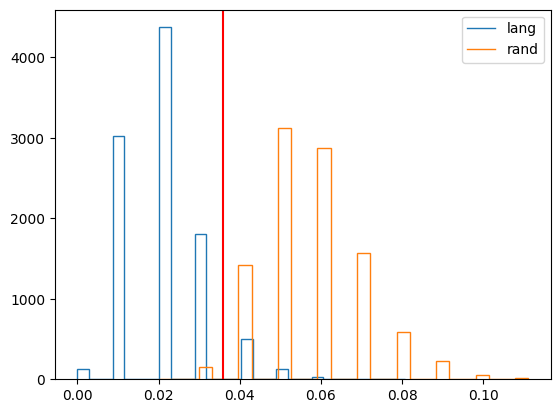

In [27]:
def plot_stat_distr(crit_stat_f, text_len, n_texts):
    lang_stat = []
    rand_stat = []

    for i in range(n_texts):
        lang_text = generate_rand_lang_text(text_len)
        rand_text = generate_random_text(text_len)

        lang_stat.append(crit_stat_f(lang_text))
        rand_stat.append(crit_stat_f(rand_text))

    ax = plt.subplot()

    counts1, bins1 = np.histogram(lang_stat, int(np.ceil(3*np.log(n_texts))))
    ax.stairs(counts1, bins1)

    counts2, bins2 = np.histogram(rand_stat, int(np.ceil(3*np.log(n_texts))))
    ax.stairs(counts2, bins2)

    ax.legend(["lang", "rand"])


n = 100
S = 10000 #int(1000*np.ceil(0.5*np.sqrt(n)))

plot_stat_distr(lambda text: crit_12_stat(text, 1), n, S)
plt.axvline(x=0.036, color='r')

k10 = {1: {10: 0, 100: 0, 1000: 0, 10000: 0},
         2: {10: 0, 100: 0, 1000: 0, 10000: 0}}  

k11 = {1: {10: 1.5, 100: 6.5, 1000: 8.85, 10000: 8.99},
        2: {10: 0.25, 100: 14, 1000: 144, 10000: 225}}   

k12 = {1: {10: 0.0675, 100: 0.035, 1000: 0.0285, 10000: 0.0285},   
        2: {10: 0.06, 100: 0.01, 1000: 0.00315, 10000: 0.0013}}    

k13 = {1: {10: 0.16, 100: 0.14, 1000: 0.15, 10000: 0.16} ,    
        2: {10: 0.075, 100: 0.21, 1000: 0.21, 10000: 0.21}}   

k30 = {1: {10: -1.715, 100: 0.05, 1000: 0.3, 10000: 0.3} ,     
        2: {10: -2.67, 100: -0.88, 1000: 0.18, 10000: 0.45}} 

k51 = {1: {10: 13.5, 100: 1.9, 1000: 0.1, 10000: 0.1} ,   
        2: {10: 300.4, 100: 264, 1000: 108, 10000: 1.25}} 

ks = {10: 2.125, 100: 0.75, 1000: 0.475, 10000: 0.38}   

## Генерування вибірок текстів 

Було згенеровано по 4 вибірки текстів довжини $L$ розмірів $N(L)$:

| L    | N |
| -------- | ------- |
| 10  | 10000 |
| 100 | 10000    |
| 1000    | 10000    |
| 10000    | 1000    |

для справжніх текстів, та випадкових (і не дуже) текстів утвореними усіма видами спотворень


Для кожної вибірки було застосовано усі критерії та обчислено відповідні ймовірності помилок 1-го та 2-го роду. Результати записано в велику табличку.


Тут:
- FR (false random) - помилка розпізнавання природнього тексту як випадкового (помилка першого роду, або FP (false positive)).
- FL (false language) - помилка розпізнавання випадкового тексту як природнього (помилка другого роду, або FN (false negative)).

In [11]:
def count_errors(rand_text_gen, crit_stat_f, crit_val, text_len, n_texts):
    TL_count = 0
    FL_count = 0

    TR_count = 0
    FR_count = 0
    
    for i in range(n_texts):
        lang_text = generate_rand_lang_text(text_len)
        rand_text = rand_text_gen(text_len)

        CL = crit_stat_f(lang_text)
        CR = crit_stat_f(rand_text)

        if CL <= crit_val:
            TL_count += 1
        else:
            FR_count += 1

        if CR > crit_val:
            TR_count += 1
        else:
            FL_count += 1


    return FR_count / n_texts, FL_count / n_texts


col_names = ["crit_name", "crit_val", "rand_gen", "l_gram", "L", "FL_prob", "FR_prob"]
data = pd.DataFrame(columns=col_names)

rand_gens = [generate_random_text, generate_recur, generate_enc_affine1,
             generate_enc_affine2, 
             lambda text: generate_enc_vigenere(text, 1),
             lambda text: generate_enc_vigenere(text, 5),
             lambda text: generate_enc_vigenere(text, 10)]

rand_gens_names = ["true_rand", "recur_rand", "affine1", "affine2",
                   "vigenere1", "vigenere5", "vigenere10"]


criteria = [crit_10_stat, crit_11_stat, crit_12_stat, crit_13_stat, crit_30_stat, crit_51_stat]
criteria_names = ["1.0", "1.1", "1.2", "1.3", "3.0", "5.1"]
crit_vals = [k10, k11, k12, k13, k30, k51]

n_texts = {10: 10000, 100: 10000, 1000: 10000, 10000: 1000}


for rand_gen in zip(rand_gens, rand_gens_names):
    for L in [10, 100, 1000, 10000]:
        N = n_texts[L]
        for criterion in zip(criteria, criteria_names, crit_vals):
            for l in [1, 2]:
                crit_stat = lambda text, l=l: criterion[0](text, l)
                crit_val = criterion[2][l][L]
                FR_prob, FL_prob = count_errors(rand_gen[0], crit_stat, crit_val, L, N)

                new_entry = pd.DataFrame([(criterion[1], crit_val, rand_gen[1], l, L, FL_prob, FR_prob)], 
                                         columns=col_names)
                data = pd.concat([data, new_entry], ignore_index = True)


C:\Users\Lollo\AppData\Local\Temp\ipykernel_37072\1002958639.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, new_entry], ignore_index = True)


Окремо блок коду під структурний критерій (із технічних причин)

In [12]:
for rand_gen in zip(rand_gens, rand_gens_names):
    for L in [10, 100, 1000, 10000]:
        N = n_texts[L]
        criterion = [deflate_compression_ratio, 'deflate structural', ks]
        
        crit_val = ks[L]
        FR_prob, FL_prob = count_errors(rand_gen[0], deflate_compression_ratio, crit_val, L, N)

        new_entry = pd.DataFrame([('deflate structural', crit_val, rand_gen[1], None, L, FL_prob, FR_prob)], 
                                    columns=col_names)
        data = pd.concat([data, new_entry], ignore_index = True)

## Експорт в ексель табличку :)

In [21]:
print(len(data.index))
data = data.sort_values(by=['rand_gen', 'L', 'l_gram', 'crit_name'])
data.head(50)

with pd.ExcelWriter('full_results.xlsx', mode='a') as w:
    data.to_excel(w, sheet_name='All Probs')

364


## Результати

![t1](rand.png "t1")

![t1](rec.png "t1")

![t1](aff1.png "t1")

![t1](aff2.png "t1")

![t1](vig1.png "t1")

![t1](vig5.png "t1")

![t1](vig10.png "t1")

## Висновки

Основними труднощами з якими довелось стикнутись в ході виконання лабораторної роботи було:

- знайти книгу "Україна не росія" в форматі, який дозволятиме зчитування тексту (а не скан)
- розібратись, де ліво, а де право (для статистик критеріїв)
- написати протокол


Всю логіку, що, чому і як працює, ми проговорювали на захисті, можна я не буду це все розписувати тут, відпустіть будь ласка...

## P.S. Короткий опис алгоритму DEFLATE

DEFLATE поєднує в собі ідеї алгоритму кодування LZ77 та кодів Хаффмана:

- LZ77: Даний алгоритм працює за принципом заміни підпослідовностей символів на back-reference'и на позиції, де такі послідовності вже зустрічались раніше. Відсилання назад робиться лише до певної довжини (так званого вікна), розмір цього вікна і є параметром стиснення на вхід DEFLATE 
- Huffman: Дерево Хаффмана на основі частот символів, будує коди таким чином, щоб частим символам відповідали коротші коди.
Для DEFLATE це дерево дещо модифіковане з розширеним алфавітом, щоб краще працювати із текстом отриманим після LZ77.
